# Machine Learning in Python - Project 1

Due Friday, March 11th by 5 pm.


Mou Jin s2103110 

Yuan Wei s2114679

Siying Zhu s2252951

## 0. Setup

###Uploading data to the colab

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/project1')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Final project1.ipynb'	'project1(2).ipynb'   the_office.csv


###Packages

In [2]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

###Data

In [3]:
# Load data
d = pd.read_csv("the_office.csv")

## 1. Introduction



This report aims to use the_office.csv data to create a logistic regression model that captures the underlying correlations between imdb_rating and other variables and then uses the insights gained from this model to advise NBC Universal on producing the highest-rated reunion episode of The Office possible as a Data Scientist contractor. 

After sorting the data into numeric and categorical categories, we removed outliers and looked at how the variables were associated. Before deciding on a model, we looked at the linear regression model, the ridge regression model, the lasso regression model, and the logistic regression model. Then we compared the results of their training, testing, and mse. We finally determined to apply a logistic linear regression model for fitting and prediction based on the correlations between variables and its better performence. Finally we were able to get it with a prediction accuracy of 79 % with confusion matrix, recall, precision, F_1 score and ROC curve tests. Then we give NBC Universal our suggestions on how to create a highest-rated reunion episode. 


## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 Overviewing the data

In [4]:
# View the first few rows of data and column names
#display(d.head())
#display(d.columns)

In [5]:
# Get a concise summary of the dataframe
#display(d.info())

### 2.2 Histograms and Correlations for Numerical Features

In this section we will talk about the numerical features.

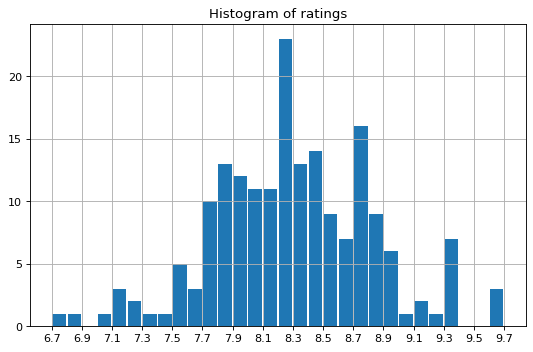

In [6]:
# Distribution of imdb_ratings
plt.subplots()
d['imdb_rating'].hist(bins = 30, rwidth = 0.9)
plt.title('Histogram of ratings')
plt.xticks(np.arange(d['imdb_rating'].min(), d['imdb_rating'].max() + 0.2, 0.2))
plt.show()

The probability distribution of imdb_rating is uniform. Then we need to observe the other numerical features.



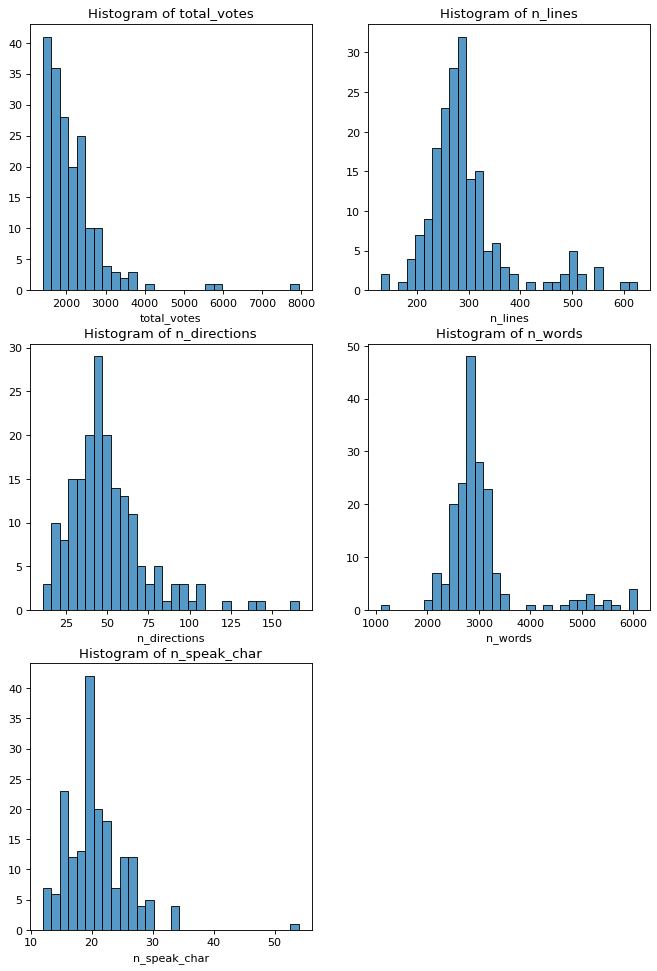

In [7]:
# Distributions of other numerical features

features1 = ['total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10,15))
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i < 5:
   sns.histplot(data = d[features1[i]], bins = 30, ax = axes[i])
   axes[i].set_title(f'Histogram of {features1[i]}')
   axes[i].set_xlabel(features1[i])
   axes[i].set_ylabel('')
  else:
    ax.remove()
plt.show()

The figures show that they fit a normal distribution. We can check their correlations.

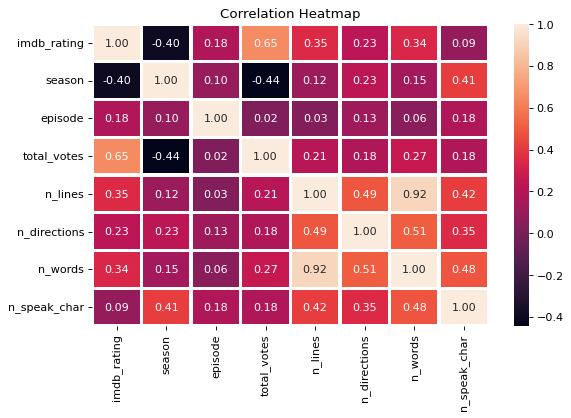

In [8]:
# Create a heatmap to check the correlation between imdb_rating and other parameters
intfeat = ['imdb_rating', 'season', 'episode', 'total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char']
sns.heatmap(d[intfeat].corr(), annot=True, fmt='.2f', linewidths=2)
plt.title("Correlation Heatmap")
plt.show()

Observed from the heatmap, we can see that total_votes is highly related to imdb_rating, in which the correlation coefficient reaches 0.65, while season, n_lines and n_words have the correlation coefficient reaches around 0.30 to 0.40. Episode, n_directions and n_speak_char show a lower relationship with imdb_rating.

### 2.3 Categorical Features

In this section we will talk about the categorical features.

We defined a function named uni_name(data, feature) to return a dictionary of unique names contained in each feature.

In [9]:
namefeatures = ['director', 'writer', 'main_chars']
unique_names = uni_name(d, namefeatures)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


We defined a function named involve_times(data, dic, feature) to return a dataframe of the number of involving times for each person in the feature.

In [10]:
# Total times involved for each director

direct_times = involve_times(d, unique_names, 'director')

In [11]:
# Total times involved for each writer

write_times = involve_times(d, unique_names, 'writer')

In [12]:
# Total times involved for each main character

perform_times = involve_times(d, unique_names, 'main_chars')

### 2.4 Anomaly Detection

#### 2.4.1 Detect Outliers

An outlier is any data point significantly different from other observations in the set, which can seriously affect the analysis and statistical modelling results.
Most parametric statistics, such as mean, standard deviation and correlation, and any statistics based on these parameters, are susceptible to outliers. Therefore, we need to remove outliers before we create our model.

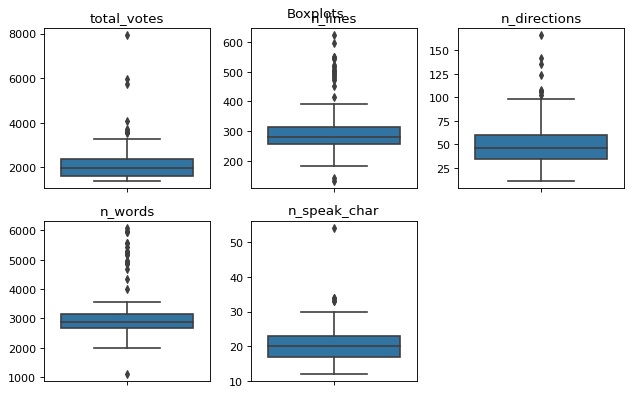

In [13]:
# Boxplots
fig, axes = plt.subplots(nrows = 2, ncols = 3)
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i < 5:
    sns.boxplot(y = d[features1[i]], ax = ax) 
    ax.set_title(features1[i])
    ax.set_ylabel("")
  else:
    ax.remove()

plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

Boxplot can be used to virtualize whether outliers exist. After observing the figures above, we can conclude that the outliers exist, so we need to remove them to ensure accuracy.

We defined a function named find_boundaries(array1D, fold) to check outliers

In [14]:
# Check outliers
display(outlier_info)

,total_votes,n_lines,n_directions,n_words,n_speak_char
Upper,3519.75,403.375,99.0,3847.125,32.0
Lower,493.75,166.375,-5.0,1964.125,8.0
Outliers,9.00,19.000,8.0,19.000,5.0


The table above shows the outliers in different variables.

#### 2.4.2 Remove Outliers

In [15]:
# Remove outliers
d_move_outlier = d.copy()

for i in features1:
  upper_boundary_, lower_boundary_ = find_boundaries(d_move_outlier[i], 1.5)
  d_move_outlier[i] = np.where(d_move_outlier[i] > upper_boundary_, np.nan, 
                               np.where(d_move_outlier[i] < lower_boundary_, np.nan, d_move_outlier[i]))
    
d_move_outlier = d_move_outlier.dropna(axis = 0)
d_move_outlier.shape

(156, 13)

#### 2.4.3 Correlations After Removing Outliers

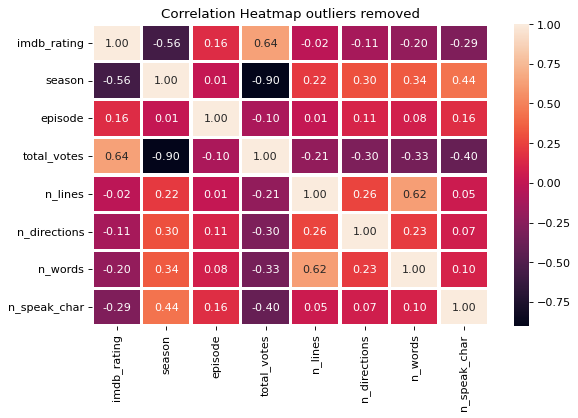

In [16]:
sns.heatmap(d_move_outlier[intfeat].corr(), annot=True, fmt='.2f', linewidths=2)
plt.title("Correlation Heatmap outliers removed")
plt.show()

Observed from the heatmap, we can see that total_votes is still highly related to imdb_rating, in which the correlation coefficient reaches 0.64, while the correlation coefficient between season and imdb_rating significantly increased at 0.56. Except for n_speak_char, other parameters show a low relationship with imdb_rating.

#### 2.4.4 Categorical Features After Removing Outliers

In [17]:
# Unique names after removing outliers
uniname_move_outlr = uni_name(d_move_outlier, namefeatures)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


We defined a function named rating_means(data, dic, feature, float = 2) to return a dataframe of the mean rating of each person.

In [18]:
# Mean ratings for each director/ writer/ main character
director = rating_means(d_move_outlier, uniname_move_outlr, 'director')
writer = rating_means(d_move_outlier, uniname_move_outlr, 'writer')
main_character = rating_means(d_move_outlier, uniname_move_outlr, 'main_chars')

## 3. Model Fitting and Tuning

### __3.1 Create related functions__

We defined three functions: 

feature_high(data, feature, uniname, high_rate): return a list that contains the values with high rate within the feature

str_num(data, feature, uniname, high_rate): return a new dataframe with a new feasture that is derived from feature

model_fit(X, y_hat, y, plot = False): return the root mean squared error of a fitted model based on provided X and y values.



### __Create new features__
Change string variables "director", "writer", "main_chars" into new variables "director_high", "writer_high", "main_chars_high"
- `director_high`: dummy variable, 1 if the mean rating of episodes of the director is above 80% quantile
- `writer_high`: dummy variable, 1 if the mean rating of episodes of the writer is above 80% quantile
- `main_chars_high`: dummy variable, 1 if one of the welcomed main characters appears in the episode.Welcomed main characters is a list that contain names of characters whose playing episodes get rating above the 80% quantile

In [21]:
d_ = d_move_outlier.copy()
d__ = str_num(d_, "director", uniname_move_outlr, 0.8)
d__ = str_num(d__, "writer", uniname_move_outlr, 0.8)
d__ = str_num(d__, "main_chars", uniname_move_outlr, 0.8)
d__.describe()

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,director_high,writer_high,main_chars_high
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.00000,156.000000
mean,5.474359,12.564103,8.160897,1966.762821,275.493590,45.583333,2827.519231,19.871795,0.102564,0.24359,0.884615
std,2.400131,7.056618,0.451174,439.416932,39.523043,16.724314,296.625831,3.770373,0.304366,0.43063,0.320514
min,1.000000,1.000000,6.700000,1393.000000,180.000000,11.000000,1986.000000,12.000000,0.000000,0.00000,0.000000
25%,3.000000,6.000000,7.900000,1612.000000,252.750000,33.000000,2635.500000,17.000000,0.000000,0.00000,1.000000
50%,6.000000,12.000000,8.200000,1863.500000,273.000000,44.000000,2827.500000,20.000000,0.000000,0.00000,1.000000
75%,8.000000,18.250000,8.500000,2312.250000,298.250000,55.000000,3043.250000,22.000000,0.000000,0.00000,1.000000
max,9.000000,28.000000,9.200000,3282.000000,390.000000,98.000000,3556.000000,30.000000,1.000000,1.00000,1.000000


### __3.2 Choose the variables__

Draw pair plots to observe variables.

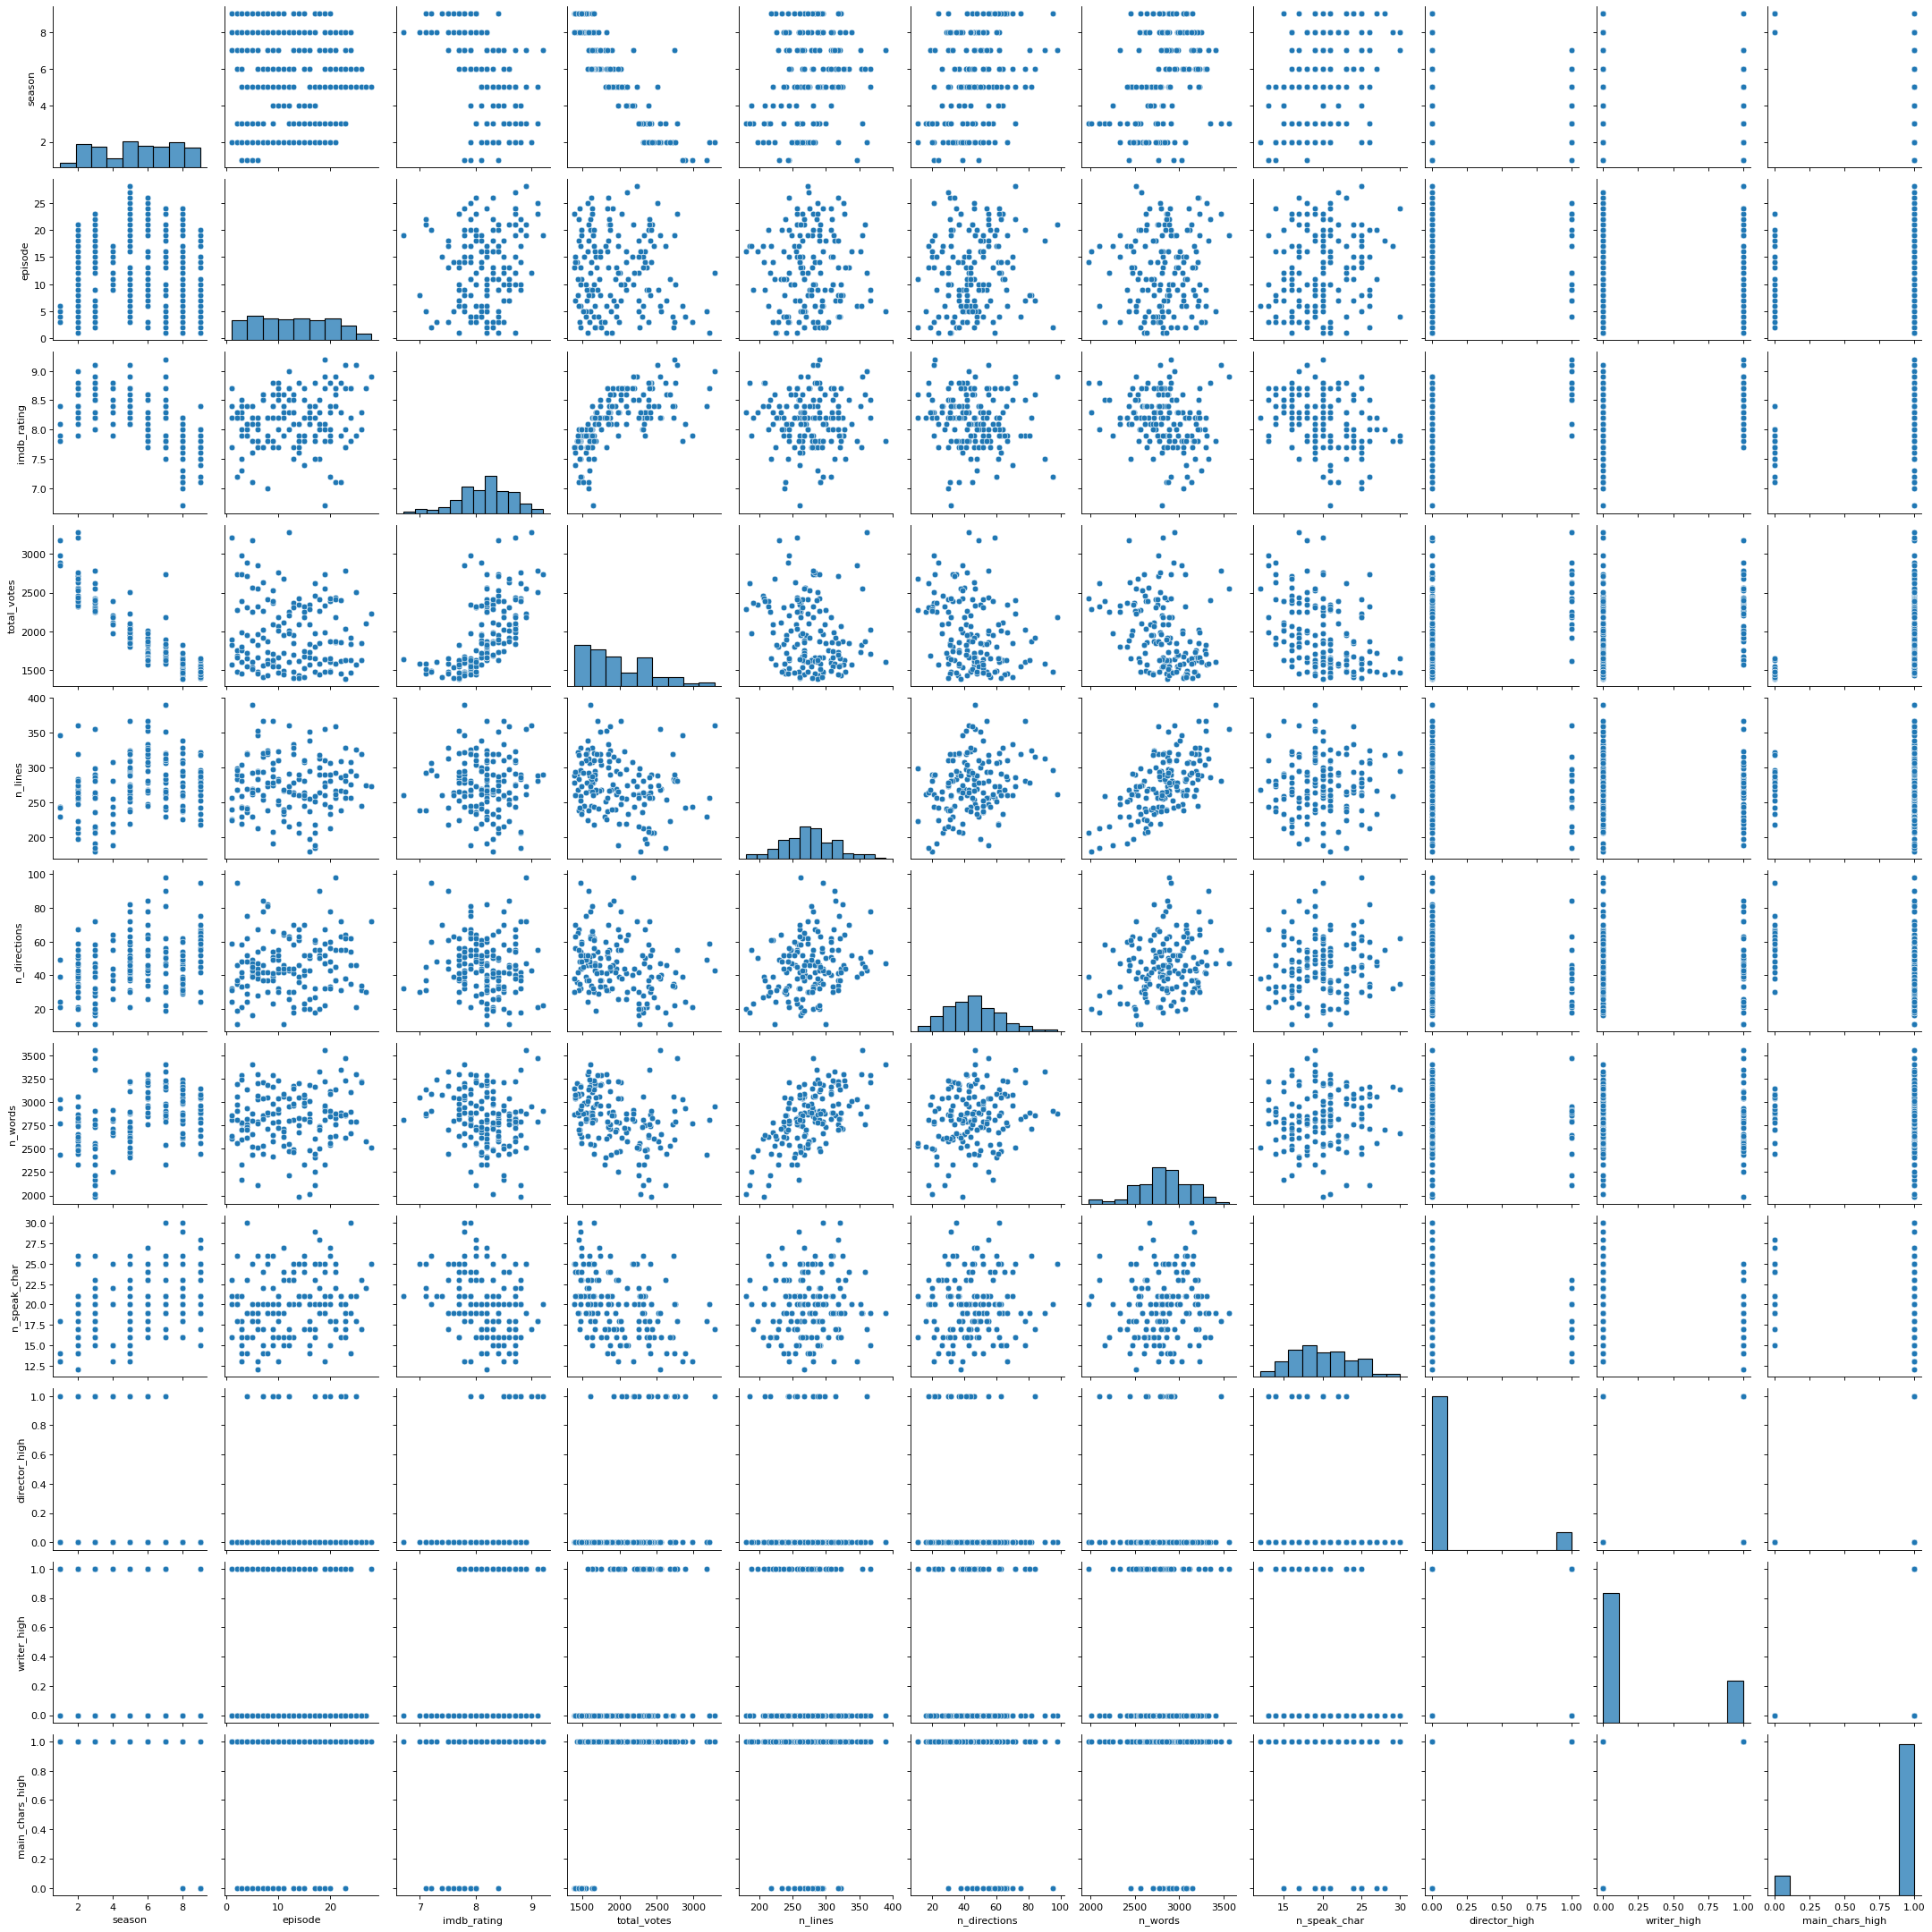

In [22]:
sns.pairplot(data = d__)

- From the pair plots and heatmap above, we find that all of `total_votes`, `n_words`, `n_speak_char`, `director_high`, `writer_high`, and `main_chars_high` are relatively highly related with `imdb_rating`.

- `n_lines` and `n_directions` may also improve our model, we can add to our model to check their coeffients.
- Therefore, we select `total_votes`,`n_lines`, `n_directions`, `n_words`, `n_speak_char`, `director_high`, `writer_high`, and `main_chars_high` as independent variables

### __3.3 Split data into train and test sets__

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# extract numeric features
features_num = ["total_votes", "n_lines", "n_directions", "n_words", "n_speak_char"]
X_num = d__[features_num]
# Standardizing numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(np.array(X_num))

# extract dummy features
features_dummy = ["director_high", "writer_high", "main_chars_high"]
X_dummy =np.array(d__[features_dummy])

# combine two features
X = np.concatenate((X_num, X_dummy),axis=1)

# extract dependent variable y
y = d__["imdb_rating"]
y = scaler.fit_transform(np.array(y).reshape(-1,1)).flatten()


# X is feature matrix, add intercept term to X
X = np.c_[np.ones(X.shape[0]),
         X]

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

print("done")

done


### __3.4 Building models__

#### _3.4.1 Choose model_

We evaluated the linear regression model, ridge regression model, lasso regression model, and logistic regression model before deciding on a model. Then we compared their training, testing, and mse scores. The model will perform better if the training and testing scores are greater, and the mse is lower.

The linear regression model is builted as follows:

$$ y = \beta_0 + \beta_1 \, x_1 + \beta_2 \, x_2 + \beta_3 \, x_3 + \beta_4 \, x_4 + \beta_5 \, x_5 + \beta_6 \, \mathbb{1}_{s_1} + \beta_7 \, \mathbb{1}_{s_2} + \beta_8 \, \mathbb{1}_{s_3}$$

| | | | |
|----------|----------|----------|----------|
|$$ x_1: \text{total_votes} $$ |$$ x_2: \text{n_lines} $$ |$$ x_3: \text{n_directions} $$  | $$ x_4: \text{n_words} $$ |
|$$ x_5: \text{n_speak_char} $$|$$ s_1: \text{director_high} $$|$$ s_2: \text{writer_high} $$  | $$ s_3: \text{main_chars_high} $$ | 






The training score and the testing score are 0.5301 and 0.4018 respectively which are relatively low. The mse is 0.65 which means the accuracy of this model is low.

The ridge regression model is built through:

<font size = 4> $$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2_2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$  </font>

$\boldsymbol{X} = \big[ \boldsymbol{1},\, \boldsymbol{x},\, \boldsymbol{\mathbb{1}_{s}} \big]$.
$\beta = [\beta_1, \, \beta_2, \, \beta_3, \, \beta_4, \, \beta_5, \, \beta_6, \, \beta_7]$.

The training score and the testing score are 0.4457 and 0.3273 respectively for this model which are relatively low and the mse is 0.71 which means the accuracy of this model is low.

The lasso regression model is built through:

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert_2^2 + \alpha \lVert \boldsymbol{\beta} \rVert_1. $$


The training score and the testing score are 0.4019 and 0.0.357 respectively for this model which are relatively low.The mse is 0.72 which means the accuracy of this model is low.

So we choose logistic regression finally.

#### _3.4.2 Logistic regression_

Below are functions from MLP workshop7, which will help in our later modelling 

We difined three functions: 

tidy_scores(score_dict): to tidy the output into a dataframe

pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]): to creates the matplotlib graph to make the confmat look nicer

roc_plot(threshold=0.5): for plotting ROC curve

Based on the baseline linear regression, we change `y` variable into a dummy variable, `y` is 1 if the `imdb_rating` of the episode is above 50%

In [25]:
y_dummy = (y > np.quantile(y, q=0.5)) + 0

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_dummy, test_size=0.3, 
                                                                    shuffle=True, stratify=y_dummy, random_state=42)


Fitting the model

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

logr = LogisticRegression(fit_intercept=False, C=2.121147, random_state=1234).fit(X_train_log, y_train_log)

# output the estimated coef.
beta_logr = logr.coef_[0]
print(f"Coefficients: {np.round(beta_logr, 4)}")

# calculate scores
# Training_score_logr = round(logr.score(X_train_log, y_train_log), 4)
# print(f"Training score: {Training_score_logr}")
# Testing_score_logr = round(logr.score(X_test, y_test_dummy), 4)
# print(f"Testing score: {Testing_score_logr}")
print("MSE of the fitted model:", mean_squared_error(y_test_log, logr.predict(X_test_log)))
print("Accuracy of the fitted model:", accuracy_score(y_test_log, logr.predict(X_test_log)))
print("AUC of the fitted model:", roc_auc_score(y_test_log, logr.predict(X_test_log)))

Coefficients: [-1.1473  1.1297  0.2676  0.0288 -0.1625 -0.1096  1.5977  0.3029  0.578 ]
MSE of the fitted model: 0.2127659574468085
Accuracy of the fitted model: 0.7872340425531915
AUC of the fitted model: 0.762218045112782


<font size = 2> $$ y = -1.1473 + 1.1297 \, x_1 + 0.2676 \, x_2 + 0.0288 \, x_3 - 0.1625 \, x_4 - 0.1096 \, x_5 + 1.5977 \, \mathbb{1}_{s_1} + 0.3029 \, \mathbb{1}_{s_2} + 0.5780 \, \mathbb{1}_{s_3}$$ </font>

The accuracy of this model($R^2$) is 0.79.

Test above model using confusion matrix, recall, precision, F_1 score and ROC curve

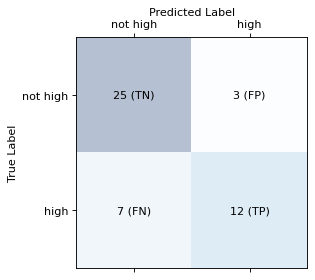

precision: 0.8
recall: 0.6316
F 1: 0.7059


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred_log = logr.predict(X_test_log)
confmat = confusion_matrix(y_true = y_test_log, y_pred=y_pred_log)
pretty_confusion_matrix(confmat, ["not high", "high"], "",  labeling=True)

print(f"precision: {round(precision_score(y_test_log, y_pred_log),4)}")
print(f"recall: {round(recall_score(y_test_log, y_pred_log),4)}")
print(f"F 1: {round(f1_score(y_test_log, y_pred_log),4)}")

By the right predictions are positioned on the diagonal of the table in this confusion matrix observe that the errors are low. The Recall and Precision are relatively high at 0.6316 and 0.8 respectively. The F_1 score is high at 0.7059.

   false positive rate  true positive rate  threshold
0             0.000000            0.000000        2.0
1             0.107143            0.631579        1.0
2             1.000000            1.000000        0.0
AUC value: 0.762218045112782


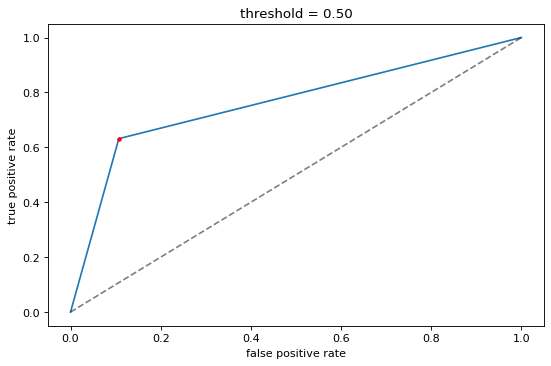

In [28]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, precision_recall_curve

roc_calc = roc_curve(y_true = y_test_log, y_score = y_pred_log)
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

# Values for ROC based on different threshold 
print(roc)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test_log, y_score = y_pred_log))

#ROC curve drawing by using the helper function roc_plot above

roc_plot(threshold=0.5)


The AUC value is high at 0.76.




Using RandomizedSearchCV to find the Best C

In [29]:
from scipy.stats.distributions import uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'C':loguniform(C_list[0], C_list[-1])}

log_rs = RandomizedSearchCV(LogisticRegression(), 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs.fit(X_train_log, y_train_log)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_iter=60,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc0c2004e90>},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [30]:
#About the summary of best 6 models 

log_rs_df = pd.DataFrame(log_rs.cv_results_)
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
16,2.121147,0.740935,0.028424,0.725541,0.079427
57,0.472916,0.747832,0.031271,0.725541,0.079427
36,2.1321,0.740935,0.028424,0.725541,0.079427
40,0.169665,0.743234,0.029283,0.725541,0.074042
26,0.497744,0.747832,0.031271,0.725541,0.079427


Based on above models, we think logistic model is best, its prediction accuracy is about 79% in testing data.

## 4. Discussion & Conclusions


###_4.1 Model Overview_
`Total_votes`, `n_lines`, `n_directions`, `n_words`, `n _speak_char`, `director_high`, `writer_high`, and `main_chars_high` are the final variables we chose to train our Logistic regression model. We can see that the model has a good prediction effect through the above model check. Therefore, we can use the information gained from this model to advise NBC Universal on making The Office's highest-rated reunion episode. For the model, we know that the positive sign for the `total_votes` coefficient means an association between `total_votes` and the outcome variable: given that the larger the `total_votes` is, the easier the episode gets a higher rating on IMDB, same as `n_lines`, `n_directions`,`director_high`, `writer_high` and `main_chars_high`. However, the negative sign for the `n_words` coefficient means an association between `n_words` and the outcome variable: given that the larger the `n_words` is, the harder the episode gets a higher rating on IMDB, same as `n_speak_char`. 



###_4.2 Model Performence_
The coefficient of determination $R^{2}$, which ranges from 0 to 1, reflects the fitness of model. The larger the $R^{2}$, the better the model fit the true data. $R^{2}$ got here is high at 79%, which indicates that the logistic regression model fit the imdb_rating to a certain degree during this period. 



###_4.3 Model reliability_
All right predictions are positioned on the diagonal of the table in the confusion matrix, making it simple to visually analyse the table for prediction errors, represented by values outside the diagonal. The table shows that the errors are low. However, accuracy is not a valid metric because it can produce misleading results if the dataset is not balanced (i.e. when the number of observations in different classes varies greatly). So we need Recall and Precision to check what proportion of positive identifications was actually correct and what proportion of actual positives was identified correctly. They are 0.6316 and 0.8 respectively. The F1 score is defined as the harmonic mean of Precision and Recall. If both Precision and Recall are high, a model will get a high F1 score, but if both Precision and Recall are poor, it will get a low F1 score. A model will obtain a medium F1 score if one of Precision and Recall is low and the other is high. F1 score got here is high at 0.7059. For the ROC curve, a model with a larger AUC value has a higher accuracy rate. AUC value got here is high at 0.76.


###_4.4 Suggestions_
We can conclude that an episode contains a large number of ratings for episode on IMDB, a large number of spoken lines and a large number of lines containing a stage direction with experienced directors, writers and characters will be easier to get a higher episode rating on IMDB. At the same time, the larger the number of dialog words and the number of different characters with spoken lines are in an episode, the lower the episode rating they will get. Namely, NBC Universal should use experienced directors, writers and actors to master and perform the episode. Meanwhile, increasing the number of spoken lines and the number of lines containing a stage direction will be a good idea. Last but not least, the coefficient of total_votes is 1.1297 which is relatively high. So expanding publicity to attract more people to vote is a great idea for getting high episode rating on IMDB.



